Yann LeCun 被譽為 Deep Learning 的三巨頭之一。他的 CNN (Convolutional Neural Networks) 是讓 Neural Network 重新受到重視的主因之一。

## 8-1 初始準備

基本上和之前是一樣的, 我們就不再說明。

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## 8-2 讀入 MNIST 數據庫

### 由 Keras 讀入 MNIST

基本上和我們上次一樣, 這次因為 Keras 已偷偷把數據庫存在你的電腦, 所以會快很多!

In [3]:
from keras.datasets import mnist

Using TensorFlow backend.


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### 輸入格式整理

如果你還記得, 我們每筆輸入資料都是 28x28 的陣列, CNN 其實就是吃「圖」的, 所以基本上不用像之前把每筆資料拉平。「但。是。」平常的圖都有 R, G, B 三個 channels, 每個 channel 都是一個矩陣, 也就是一張圖可能是三個矩陣! 我們是灰階, 也就是只有一個 channel。但這件事也要明確的告訴 Keras。

換句話說, 我們的輸入每筆資料型式要從 (28, 28) 換成 (28, 28, 1)!

In [5]:
x_train[1234].shape

(28, 28)

In [6]:
# CNN 要的是 (28, 28, 1)

確認一下...

In [7]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

原來 28x28 矩陣...

In [8]:
x_train[1234].shape

(28, 28, 1)

In [9]:
X = x_train[1234]

In [10]:
X = X.reshape(28, 28)

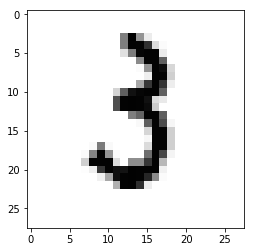

In [11]:
plt.imshow(X,  cmap='Greys')

### 輸出格式整理

和上次一樣, 我們用標準 1-hot 方式處理。

In [12]:
y_train[1234]

3

In [13]:
from keras.utils import np_utils

In [14]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [15]:
y_train[1234]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [16]:
x_train = x_train/255
x_test = x_test/255

## 8-3 打造你的 CNN

### 決定神經網路架構、讀入相關套件

CNN 我們一樣要決定用幾層的 CNN, 然後是不是每次都要做 max-pooling。再來就是拉平、送入標準神經網路 (再度要決定幾層、幾個神經元)。

我們上課的時候, 同學建議要做 3 次的 convolution + max-pooling, filter 大小都是 $5\times 5$。

* 做 <span style="color:red;">3</span> 次 convolution, 每次都接 max-pooling
* filter 大小都是 <span style="color:red;">5x5</span>, max-pooling 都用 <span style="color:red;">2x2</span> 為一小區塊

CNN 一個小技巧是每層的 filters 數目是越來越多, 上課同學建議第一層 4 個, 因為要做三次, 所以我們 filters 數分別是 <span style="color:red;">4, 8, 16</span>。做完 convolution 之後, 我們要拉平、再送入一個標準的神經網路。這個神經網路設計是這樣:

* 只有 <span style="color:red;">1</span> 個隱藏層, 使用 <span style="color:red;">9</span> 個神經元 (這也是同學建議)。

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import SGD

### 建構我們的神經網路

一開始一樣是打開個空白的神經網路。

In [18]:
model = Sequential()

第一個隱藏層一樣要告訴 Keras 我們輸入長什麼樣子。`padding` 設成 `same` 是每個 filter 會輸出原來 28x28 一樣大小的矩陣。

In [19]:
model.add(Conv2D(4, (5, 5), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))

Max-Pooling!

In [20]:
model.add(MaxPool2D(pool_size=(2,2)))

第二次 Convolution!

In [21]:
model.add(Conv2D(8, (5, 5), padding='same'))
model.add(Activation('relu'))

再 Max-Pooling!

In [22]:
model.add(MaxPool2D(pool_size=(2,2)))

第三次 Convolution!

In [23]:
model.add(Conv2D(16, (5, 5), padding='same'))
model.add(Activation('relu'))

Max-Pooling 最終回。

In [24]:
model.add(MaxPool2D(pool_size=(2,2)))

然後我們要送進一般的神經網路了。記得這是要拉平的, 還在 Keras 會幫我們做!

In [25]:
model.add(Flatten())
model.add(Dense(9))
model.add(Activation('relu'))

輸出和上次一樣!

In [26]:
model.add(Dense(10))

In [27]:
model.add(Activation('softmax'))

### 組裝

和之前比較不一樣的是我們還要做 `compile` 才正式把我們的神經網路建好。

In [28]:
#model.compile(loss="categorical_crossentropy",
#              optimizer=Adadelta(),
#              metrics=['accuracy'])

In [29]:
model.compile(loss='mse', optimizer=SGD(lr=0.07), metrics=['accuracy'])

### 檢視我們的神經網路

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 4)         104       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         808       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          3216      
__________

## 8-4 訓練

In [32]:
model.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.0090 - acc: 0.9418
Epoch 2/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.0084 - acc: 0.9455
Epoch 3/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.0079 - acc: 0.9489
Epoch 4/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.0075 - acc: 0.9513
Epoch 5/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.0072 - acc: 0.9537
Epoch 6/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.0068 - acc: 0.9558
Epoch 7/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.0066 - acc: 0.9575
Epoch 8/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.0063 - acc: 0.9594
Epoch 9/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.0061 - acc: 0.9607
Epoch 10/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.0059 - acc: 0.9620

這裡因為第一次訓練有點遜 (CNN 標準), 所以我再執行 `fit` 一次, 因此實際上是訓練了 20 次。

## 8-5 結果測試

### 分數

我們來看測試資料 (我們的 CNN 沒看過的)

In [33]:
score = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 34us/step


我們來看成績, 順便用 Python 3.6 開始的 f-string format 方式。

In [40]:
print(f'測試資料的 loss: {score[0]:.5f}')
print(f'測試資料的正確率: {score[1]}')

測試資料的 loss: 0.00578
測試資料的正確率: 0.9621


### 儲存結果

結果看來還不差, 所以我們把結果存起來。上次我們介紹分別存架構和權重的方法, 這次我們看看怎麼樣一次就存入權重 + 結構!

In [42]:
model.save('myCNNmodel.h5')

### 欣賞一下成果

我們示範一下怎麼讀回我們的神經網路。你會發現讀回來之後就可以直接使用了!!

In [43]:
del model

先把我們原來的 model 刪掉, 保證接下來的是讀進來的。我們要用一個 `load_model` 的函式。

In [44]:
from keras.models import load_model

In [45]:
model = load_model('myCNNmodel.h5')

我們用另一個方式: 每次選 5 個顯示, 看是不是有正確辨識。

In [46]:
predict = model.predict_classes(x_test)

看來真的可以直接用!!

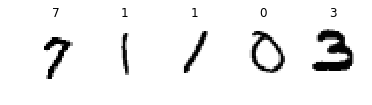

In [47]:
pick = np.random.randint(1,9999, 5)

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[pick[i]].reshape(28,28), cmap='Greys')
    plt.title(predict[pick[i]])
    plt.axis("off")

## 小結論

我們到此, 基本上是「亂做」的神經網路。有些同學在不斷試驗的過程中, 可能會發現有時會出現很糟糕的結果。因此, 接下來我們要介紹怎麼樣用些簡單的手法, 能讓學習效果比較穩定, 而且有可能可以增加學習效率。